### Carregando as Bibliotecas

In [1]:
! pip install lightgbm
! pip install xgboost

In [2]:
import plotly_express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [3]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [4]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
%matplotlib inline
plt.rcParams.update(params)

### Arquivo_02

In [5]:
df=pd.read_csv('d_f_a_2.csv',encoding = "ISO-8859-1", sep=";", low_memory=False, nrows=1000000)

In [6]:
df.shape

(140628, 83)

In [7]:
# separação na doença mais frequente desse arquivo = K40
temp = np.where(df['diag_princ'].isin(['K40']))
df40 = df.loc[temp]
# reunir tudo
df40.head(3)

,cod_muni,qtd_mora,incidencia,diag_princ,prevalencia,renda_media_mora,SITU1_entorno,SITU2_entorno,SITU3_entorno,SITU4_entorno,...,V032_domicilio02,V033_domicilio02,V034_domicilio02,V035_domicilio02,V036_domicilio02,V037_domicilio02,V038_domicilio02,V041_domicilio02,V045_domicilio02,V089_domicilio02
18,290010,8301,24,K40,0.002891,0.103943,0.463481,0.0,0.0,0.0,...,0.005892,0.399110,0.016835,0.035354,0.000000,0.010582,0.970779,0.027417,0.490861,0.509139
53,290020,16991,50,K40,0.002943,0.036980,0.548910,0.0,0.0,0.0,...,0.109294,0.194620,0.004395,0.249180,0.000176,0.024848,0.909341,0.086381,0.501875,0.498125
98,290030,14503,97,K40,0.006688,0.063205,0.887555,0.0,0.0,0.0,...,0.006756,0.374053,0.024022,0.037399,0.000409,0.006142,0.970859,0.018904,0.491913,0.508087


In [8]:
df40.shape

(2409, 83)

In [13]:
# Preparação dos arquivos de entrada (X) e saída (y)
X = df40.drop(columns=['prevalencia','diag_princ','incidencia','cod_muni'])
y = df40.loc[:,'prevalencia']

In [14]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

In [15]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

<AxesSubplot:>

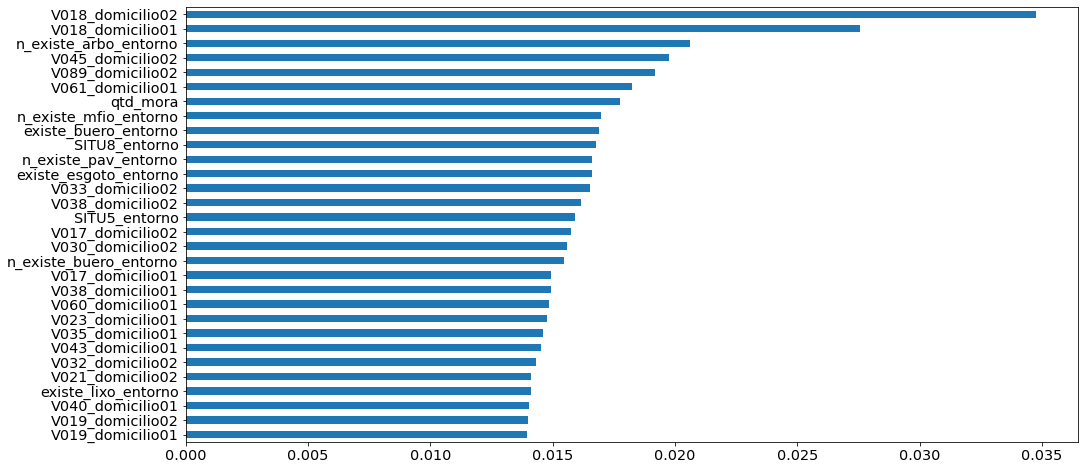

In [16]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(30).sort_values().plot.barh())

### Seleção de atributos  - acima da importância de (não_existe_pav_entorno): vide acima

In [17]:
# Preparação dos arquivos de entrada (X) e saída (y)
# Código do município foi retirado - seleção dos 8 mais importantes
X = df40[["V018_domicilio02",'V018_domicilio01',"V061_domicilio01",'V045_domicilio02',"V089_domicilio02","n_existe_mfio_entorno",
           'n_existe_arbo_entorno',"n_existe_pav_entorno"]]
y = df40.loc[:,'prevalencia']

In [18]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

In [31]:
y_train.describe

<bound method NDFrame.describe of 120031    0.004204
109445    0.003287
83144     0.004321
60011     0.006742
75376     0.010667
            ...   
15454     0.002365
120406    0.010662
36744     0.005275
72986     0.006716
39688     0.004888
Name: prevalencia, Length: 1686, dtype: float64>

### Algoritmo Referência = Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [20]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10],
              "max_features":['auto'],
              'max_depth':[10,20,30],
              'max_leaf_nodes':[2,3,4,5],
              'min_samples_leaf':[5,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 701 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.7s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [21]:
random_rf.best_params_

{'n_estimators': 8,
 'min_samples_split': 15,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 5,
 'max_features': 'auto',
 'max_depth': 30}

In [22]:
m_rf=RandomForestRegressor(n_estimators= 8,
 min_samples_split = 15,
 min_samples_leaf = 15,
 max_leaf_nodes = 5,
 max_features ='auto',
 max_depth = 30)

In [23]:
yrf = m_rf.fit(X_train,y_train)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=5,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=15, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [24]:
y_rf= yrf.predict(X_test)

In [25]:
mse_rf = round(mean_squared_error(y_test, y_rf),8)
print(mse_rf)

4.73e-06


In [26]:
errop2= (y_test - y_rf)*100/y_test
# em porcentagem
media = round(np.mean(errop2),1)
print(media)
desvio = round(np.std(errop2),1)
print(desvio)

-22.9
63.1


In [28]:
# Avaliação do erro em relação a modelo simples: média do y_train
a = np.mean(y_train)
print(round(a,4))

0.0048


In [34]:
a=[0.0048]*723 #array com a média de y_train

In [61]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_rf = mse_rf/mse_m
print(round(mse_m,8), round(mse_rf,8))
print(round(r_rf,4))

4.98e-06 4.73e-06
0.9497


### Uso do XGBoost

In [38]:
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]}

In [39]:
regressor = xgb.XGBRegressor()

In [40]:
random_search = RandomizedSearchCV(regressor,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [41]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\aferr\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   23.1s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   23.1s finished


[08:51:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { learning rate, max depth, min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_con...
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'colsa

In [42]:
print(random_search.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.4, learning_rate=0.300000012, max depth=8,
             max_delta_step=0, max_depth=6, min_child_weight=1,
             min_child_weigth=7, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [43]:
random_search.best_params_

{'min_child_weigth': 7,
 'max depth': 8,
 'learning rate': 0.4,
 'gamma': 0.2,
 'colsample_bytree': 0.3,
 'booster': 'gbtree'}

In [44]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=10)

In [62]:
mo = xgb.XGBRegressor(min_child_weigth= 7,
 max_depth = 8,
 learning_rate = 0.4,
 gamma = 0.2,
 colsample_bytree = 0.3,
 booster = 'dart') 

In [63]:
mo.fit(X_train,y_train)

[09:05:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=8,
             min_child_weight=1, min_child_weigth=7, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
y_xg = mo.predict(X_test)

In [65]:
mse_xg = mean_squared_error(y_test, y_xg)
print(mse_xg)

4.979767688340072e-06


In [68]:
errop2= (y_test - y_xg)*100/y_test # em porcentagem
print(errop2)

28093     -24.600595
60506    -121.138915
110943     33.026814
109620     13.576400
124632    -39.575197
             ...    
36559     -19.445746
110742     21.206928
83532      20.701671
59033      -1.276218
29783     -35.086698
Name: prevalencia, Length: 723, dtype: float64


In [67]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_xg = mse_xg/mse_m
print(round(mse_m,10), round(mse_xg,10))
print(round(r_rf,4))

4.9805e-06 4.9798e-06
0.9497


### Identificação dos municípios com errop2 entre -3 e 3 porcento

In [23]:
errop2.shape

(723,)

In [24]:
print(errop2)

28093     -15.452949
60506    -104.903835
110943     31.713575
109620      9.282394
124632    -90.297621
             ...    
36559     -14.449885
110742     23.881532
83532      14.104426
59033      -0.658913
29783     -35.027938
Name: prevalencia, Length: 723, dtype: float64


In [25]:
print(type(errop2))

<class 'pandas.core.series.Series'>


In [26]:
frame = { 'cod_muni': X_test['cod_muni'], "errop2": errop2 } 
result = pd.DataFrame(frame) 
print(result) 

        cod_muni      errop2
28093     310840  -15.452949
60506     315800 -104.903835
110943    355460   31.713575
109620    355290    9.282394
124632    431030  -90.297621
...          ...         ...
36559     312210  -14.449885
110742    355430   23.881532
83532     351800   14.104426
59033     315590   -0.658913
29783     311110  -35.027938

[723 rows x 2 columns]


In [27]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 723 entries, 28093 to 29783
Data columns (total 2 columns):
cod_muni    723 non-null int64
errop2      723 non-null float64
dtypes: float64(1), int64(1)
memory usage: 16.9 KB


In [28]:
a=result[result['errop2'] >-3]

In [29]:
a.head(3)

,cod_muni,errop2
110943,355460,31.713575
109620,355290,9.282394
65387,316570,52.406819


In [30]:
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 110943 to 59033
Data columns (total 2 columns):
cod_muni    344 non-null int64
errop2      344 non-null float64
dtypes: float64(1), int64(1)
memory usage: 8.1 KB


In [31]:
b_rf=a[a['errop2'] <3]

In [32]:
b_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 6270 to 59033
Data columns (total 2 columns):
cod_muni    41 non-null int64
errop2      41 non-null float64
dtypes: float64(1), int64(1)
memory usage: 984.0 bytes


In [34]:
b_rf.head(35)

,cod_muni,errop2
6270,290960,-0.711526
88296,352380,-2.186850
130626,431470,1.603068
1450,290230,0.852331
81258,351510,-0.520033
54635,314880,-0.733280
120717,430655,-2.014881
102960,354380,1.188609
136284,432000,1.491574
746,290130,-2.559518


### Alterando a margem do erro para [-5% & 5$]

In [35]:
a5=result[result['errop2'] >-5]

In [36]:
a5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 110943 to 59033
Data columns (total 2 columns):
cod_muni    356 non-null int64
errop2      356 non-null float64
dtypes: float64(1), int64(1)
memory usage: 8.3 KB


In [37]:
b5_rf=a[a['errop2'] <5]

In [39]:
b5_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 79086 to 59033
Data columns (total 2 columns):
cod_muni    55 non-null int64
errop2      55 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.3 KB


### Alterando a faixa para 10%

In [40]:
a10=result[result['errop2'] >-10]

In [42]:
a10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 110943 to 59033
Data columns (total 2 columns):
cod_muni    387 non-null int64
errop2      387 non-null float64
dtypes: float64(1), int64(1)
memory usage: 9.1 KB


In [43]:
b10_rf=a[a['errop2'] <10]

In [45]:
b10_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 109620 to 59033
Data columns (total 2 columns):
cod_muni    99 non-null int64
errop2      99 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.3 KB


### Alterando a faixa para 1%

In [46]:
a1=result[result['errop2'] >-1]

In [47]:
b1_rf=a[a['errop2'] <1]

In [48]:
b1_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 6270 to 59033
Data columns (total 2 columns):
cod_muni    29 non-null int64
errop2      29 non-null float64
dtypes: float64(1), int64(1)
memory usage: 696.0 bytes
